# *Outlines*

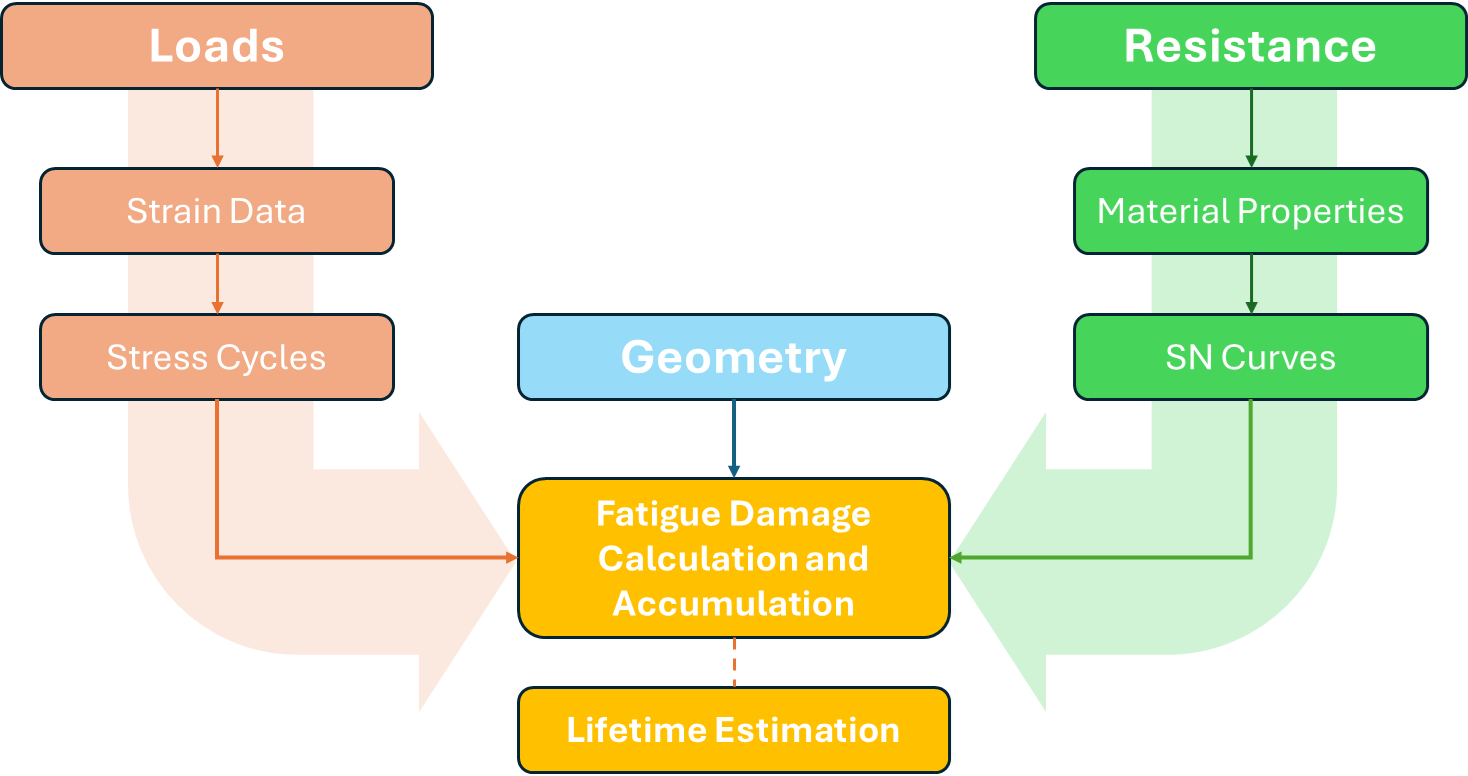


# **Introduction**

We will be using loads from [WILLOW Norther Open Source Dataset](https://zenodo.org/records/11093262) for conducting this workshop

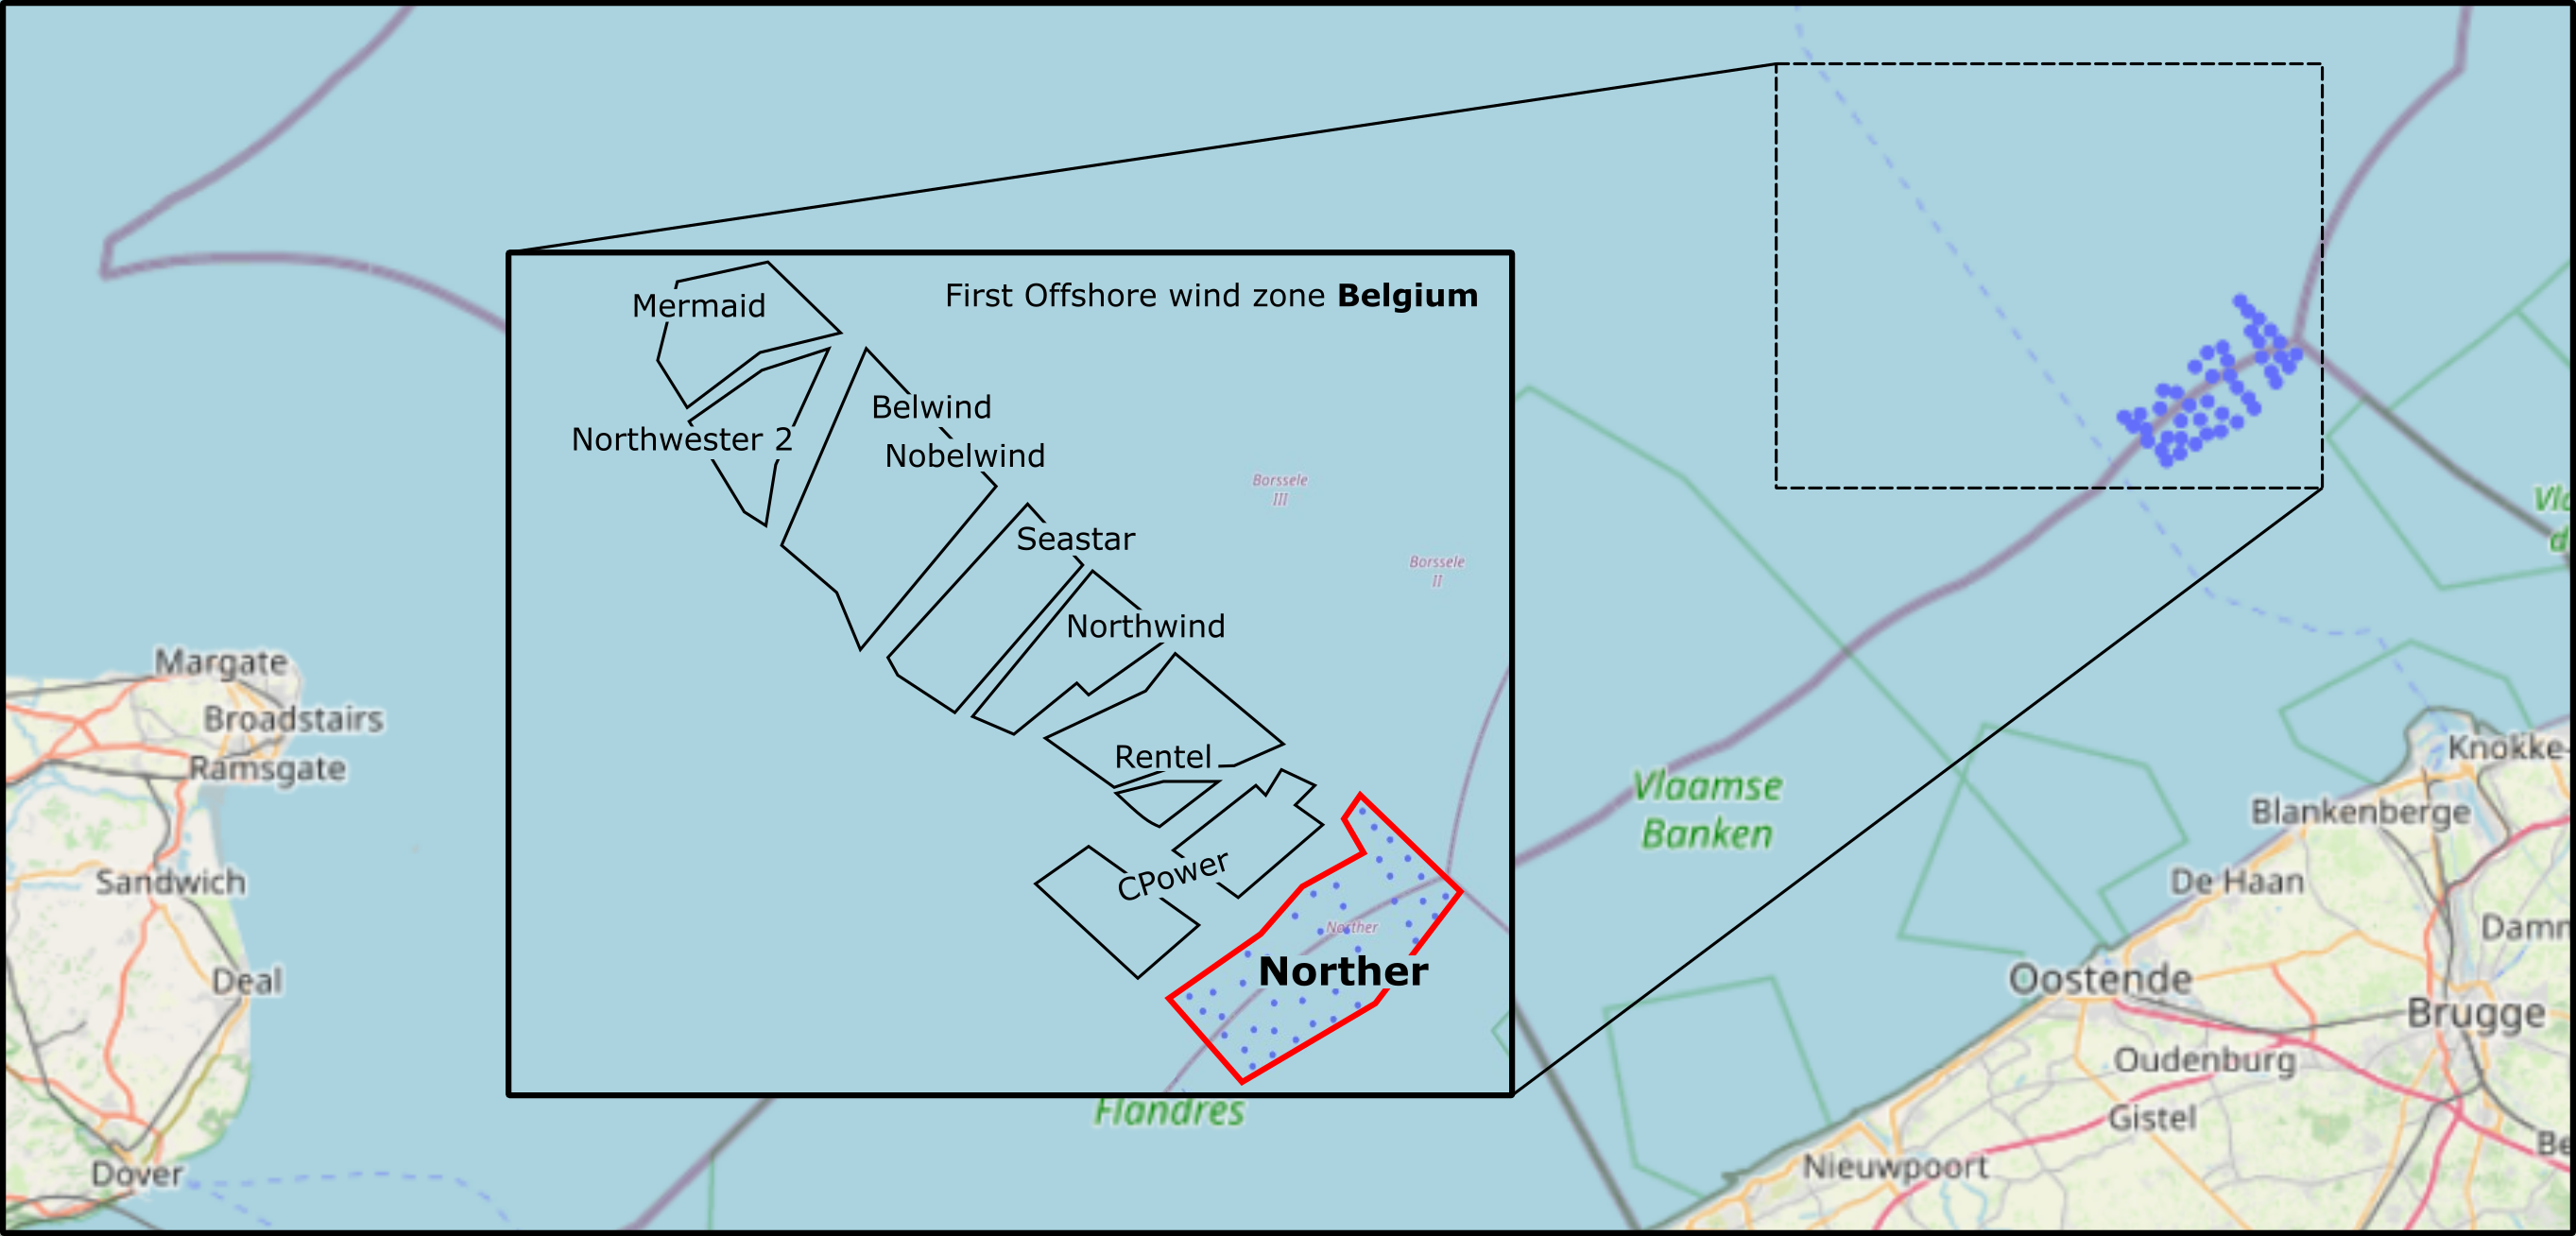



There are various sensors installed on this turbine including accelerometers, strain gauges, fiber bragg gratings (FBGs)


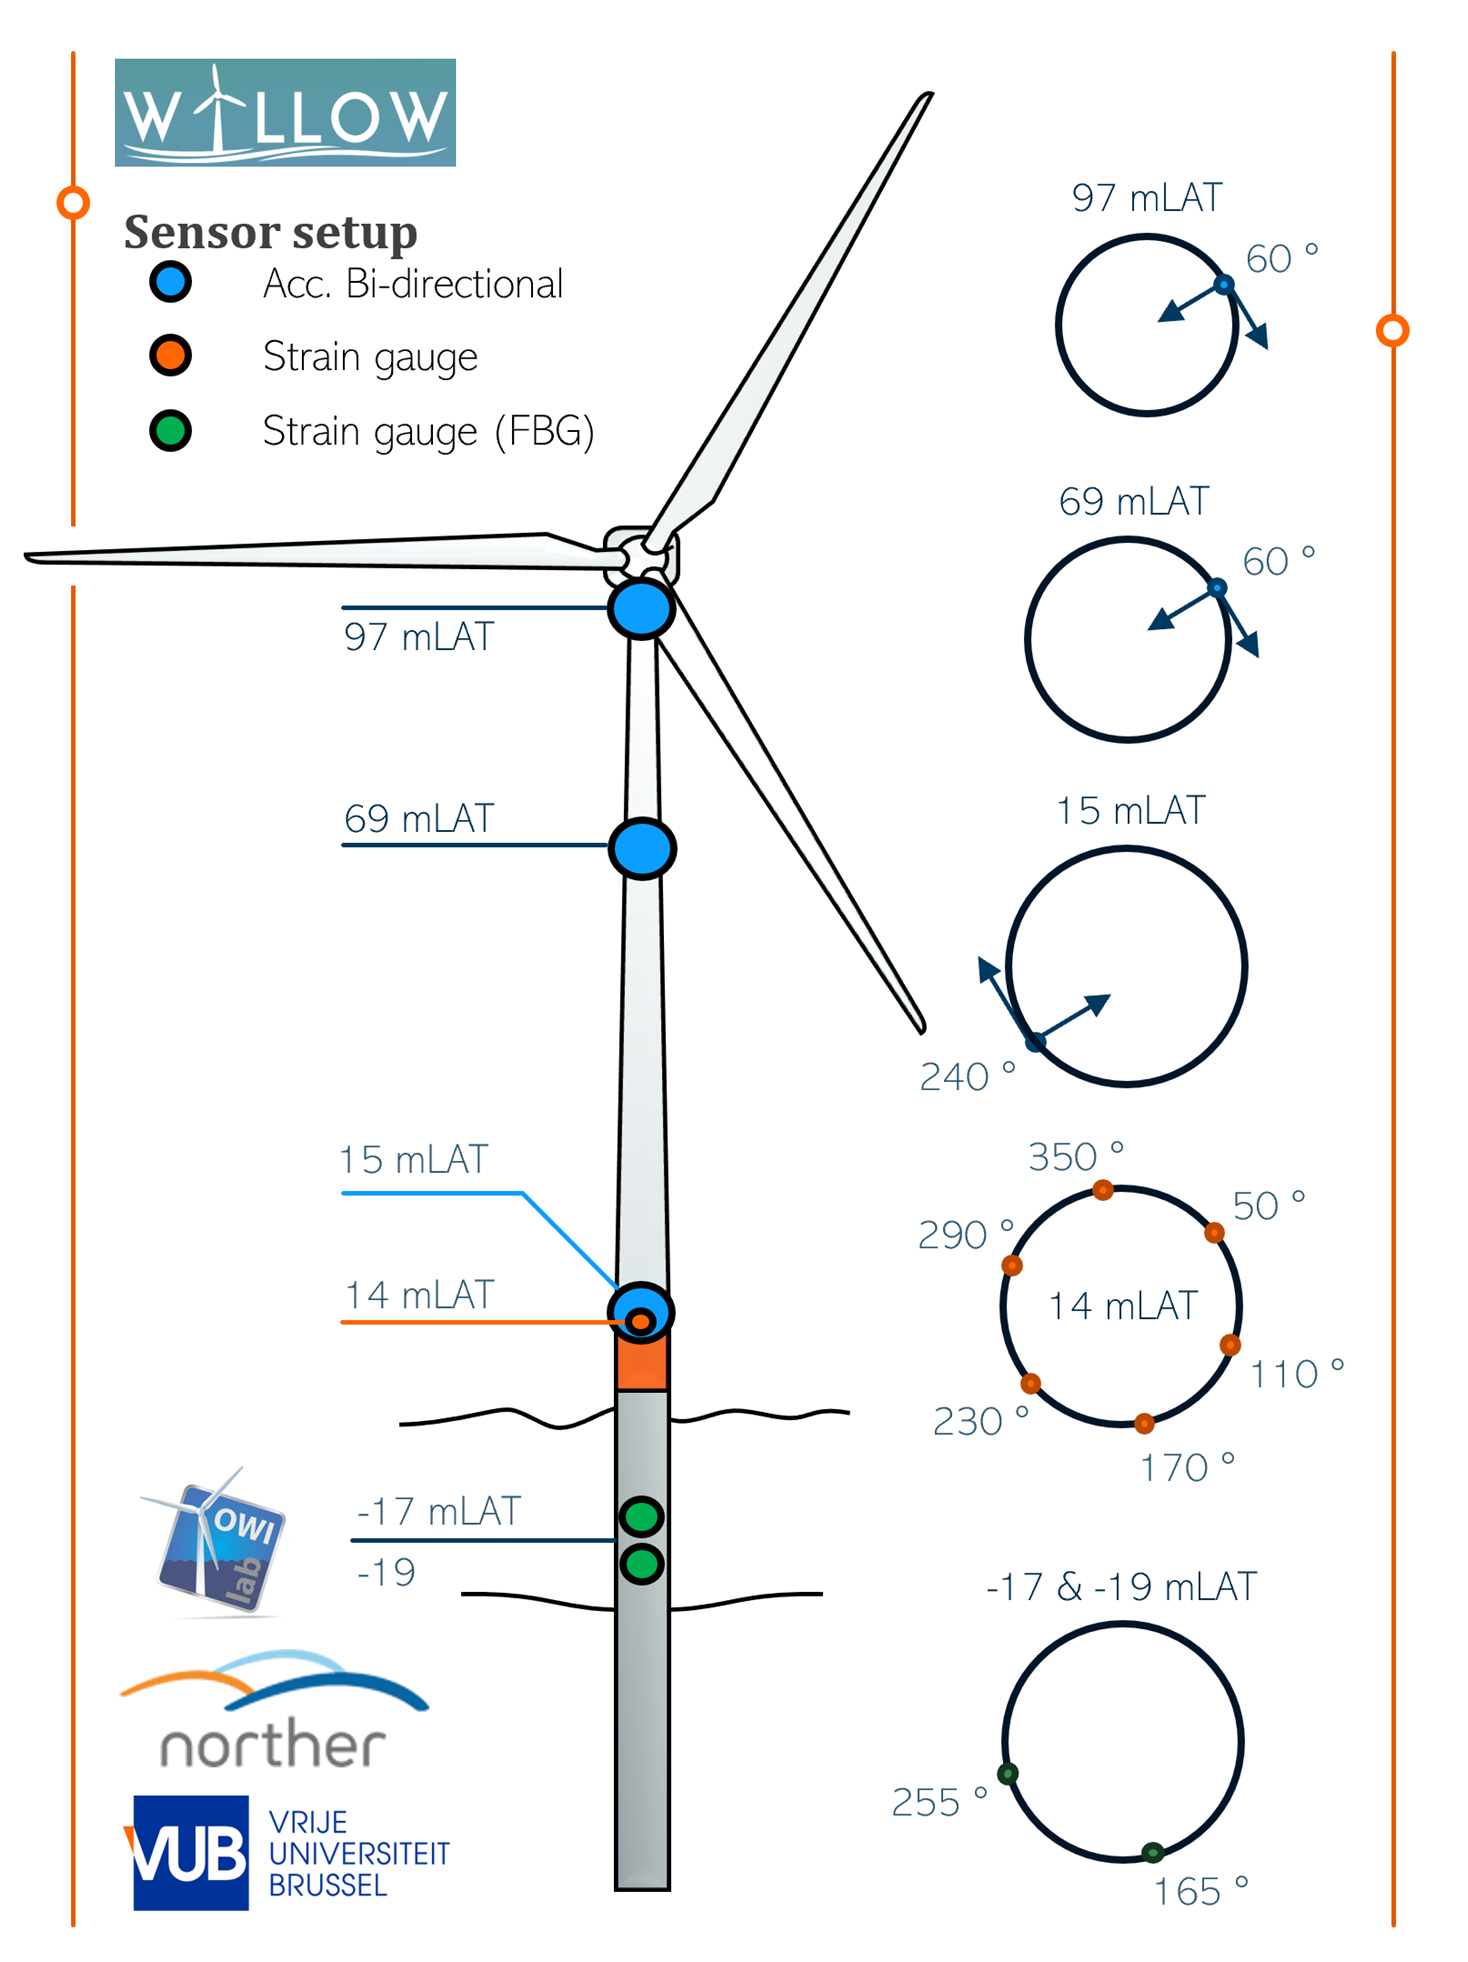

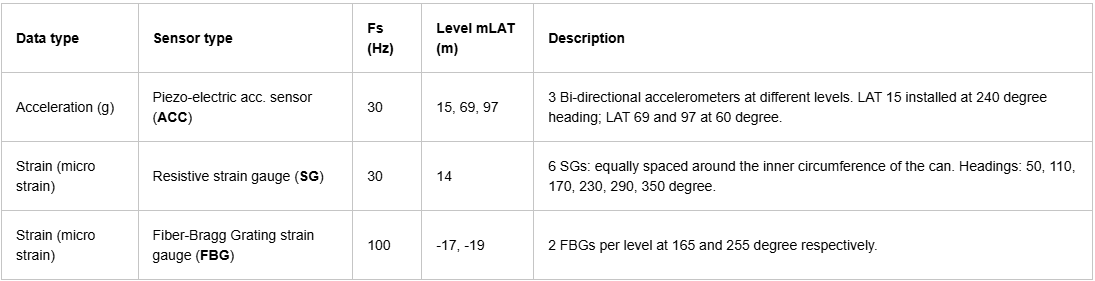


The list of SCADA parameters and the intervals for which the data is avaliable is also given as follows:

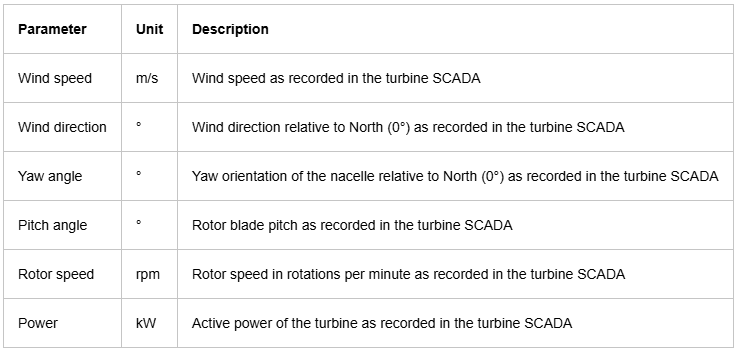


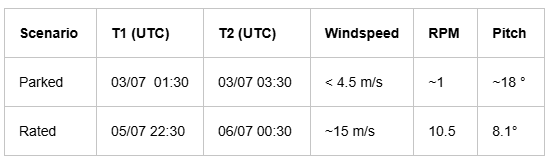


# *Loading Necessary Packages*

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Metadatabase Packages for geometry/ resistance data load
import os
import dotenv
from owimetadatabase_preprocessor.locations.io import LocationsAPI
from owimetadatabase_preprocessor.fatigue.io import FatigueAPI
from owimetadatabase_preprocessor.geometry.io import GeometryAPI
from owimetadatabase_preprocessor.results.io import ResultsAPI


# Packages for handling and processing load data
import numpy as np

# Importing py_fatigue for load signals processing, fatigue damage and crack growth calculations
import py_fatigue as pf

#Packages for Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# *Geometry - OWI MetaDataBase*

In [ ]:
## Credentials for Metadatabase
dotenv.load_dotenv()

api_root = 'https://owimetadatabase-dev.azurewebsites.net/api/v1'
TOKEN = os.getenv('OWIMETA_TOKEN')
head = {'Authorization': 'Token %s' % (TOKEN)}
api_geo = GeometryAPI(api_root=api_root, token=TOKEN)
#api_geo = GeometryAPI(api_root=api_root, uname=user,password=password)

## Geometry APIs

In [ ]:
# Name of the Turbine ()
turbine_ID = 'NRT_demo'

# Setting model definition to 'as-built NRT_demo' loads as-built metrology data from OwiMetaDataBase!
model = 'as-designed NRT_demo'

owts = api_geo.get_owt_geometry_processor(turbines = turbine_ID, model_definition = model)
owts.process_structures()

In [ ]:
list(owts.__dict__.keys())

In [ ]:
owts.all_turbines

In [ ]:
data, layout = owts.sub_assemblies[turbine_ID]['MP'].plotly()
fig = go.Figure(data=data, layout=layout)
# Set figure size in pixels
fig.update_layout(width=600, height=600)

fig.show()

In [ ]:
owts.monopile

**Check the sensors location to calculate stress extrapolation factor**

## *Static Extrapolation of Loads*
Till now, we have not considered any stress concentration factor in the cycle counting objects. These factors are important for **Stress Transformation to other locations**, **Incorporatethe effect of geometrical irregularities** and **include the effect of welds in the structure**

Consider a cantilever beam with varying cross-section and a point load applied at the tip as shown in Figure 2. The bending moment diagram in the cantilever beam is also shown.

The signal we have been using so far was stress signal measured at Section A-A of the given beam. We now have the measured stresses at Section A-A. From the bending moment diagram we notice that Section A-A is not the most critical location in the beam. At Section B-B, the bending moment is higher and there is a circumferential weld at that section as well. 

The stress signal needs to be transformed to Section B-B for calculation of the accumulated damage at Section B-B. Suppose from design, we know the bending moment diagram for the beam subjected to operation load **F** at the tip. The bending moment ratio at section A-A and section B-B is calculated as the load extrapolation factor shown in `Figure 2`. Similarly, the cross-sectional details at section A-A and section B-B are not the same. Thus, a stress extrapolation factor incorporating the effect of varying radius and second moment of area of the sections is calculated as shown in `Figure 2`. The circumferential weld at section B-B introduces a geometric irregularity and thus is accounted for a stress concentration factor. Finally a materials safety factor as per design is also included in the calculations.

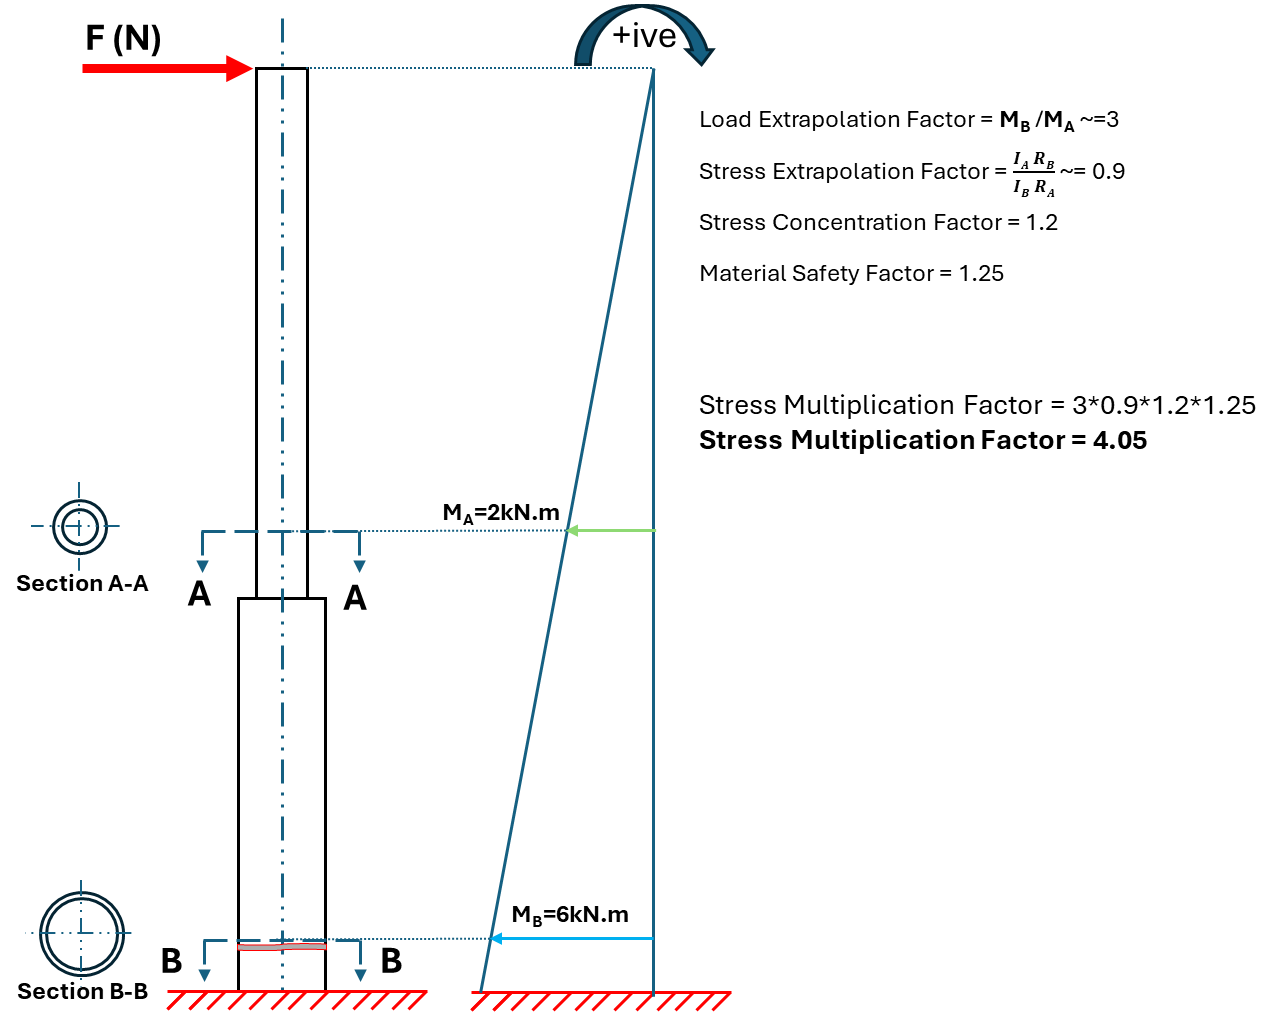

<div align="center"><em>Figure 2: Bending Moment Diagram of a Beam Illustration and Static Extrapolation Factor</em></div>

All these factors are accumulated in a single **Stress Multiplication Factor** which is used for scaling the `cycle_count` objects and thus for accumulated damage calculation at Section B-B.

In [ ]:
#owts.transition_piece
owts.monopile

In [ ]:
d_A = owts.transition_piece.at['nrt_demo_tp_03', 'Diameter from [m]']
d_A

In [ ]:
t_A = owts.transition_piece.at['nrt_demo_tp_03', 'Wall thickness [mm]']
t_A

In [ ]:
d_B = owts.monopile.at['nrt_demo_mp_11', 'Diameter from [m]']
d_B

In [ ]:
t_B = owts.monopile.at['nrt_demo_mp_11', 'Wall thickness [mm]']
t_B

In [ ]:
def moment_of_inertia(diameter, thickness):
    """
    Calculate the second moment of area (I) for a hollow circular section.
    
    Parameters
    ----------
    diameter : float
        Outer diameter in meters.
    thickness : float
        Wall thickness in millimeters.
    
    Returns
    -------
    float
        Moment of inertia (m⁴)
    """
    I = (np.pi * (diameter**4 - (diameter - 2 * (thickness / 1000))**4) / 64)
    return I

In [ ]:
I_A = moment_of_inertia(d_A, t_A)
I_B = moment_of_inertia(d_B, t_B)

SEF = (I_A*0.5*d_B)/(I_B*0.5*d_A)
SEF

# *Resistance - OWI MetaDataBase*

## *Fatigue APIs*

In [ ]:
api_fatigue = FatigueAPI(api_root=api_root, token=TOKEN)

In [ ]:
sncurves = api_fatigue.get_sncurves()
sncurve = sncurves[0]
print(f"Total number of accessible SN curves in the database currently is {len(sncurves)}.")

In [ ]:
#sncurves

In [ ]:
data, layout = sncurve.plotly()
fig = go.Figure(data=data, layout=layout)


In [ ]:
fdsa = api_fatigue.get_fatiguesubassembly(turbine=turbine_ID , subassembly="MP")

In [ ]:
fig = go.Figure(fdsa['MP'].plotly(showplot=False))
# Set figure size in pixels
fig.update_layout(width=600, height=600)

fig.show()

In [ ]:
fatigue_details = api_fatigue.get_fatiguedetails(title__icontains=turbine_ID + '_MP', modeldefinition__title='as-designed ' + turbine_ID)
fatigue_details

In [ ]:
indices = [i for i, entry in enumerate(fatigue_details) if "CW24" in str(entry)]
crit_detail = fatigue_details[indices[0]]
crit_detail

In [ ]:
crit_detail.buildingblock.title

In [ ]:
crit_detail.sncurves

In [ ]:
sn = crit_detail.sncurves['sncurvein']

In [ ]:
sn.m

In [ ]:
sn_comp = pf.SNCurve(
    slope=sn.m, 
    intercept=sn.log_a, 
    environment = sn.environment, 
    curve = sn.curve, 
    norm = sn.norm,
    color='g'
)

In [ ]:
sn_comp

# *Results - OWI MetaDataBase*

**Demonstration of Stress concentration factors for as-built weld geometry from results module for a circumferential weld.
Extract the mean or maximum value for further analysis**

In [ ]:
api_res = ResultsAPI(api_root=api_root, token=TOKEN)

analyses = api_res.get_analyses()

analyses['data']

result_scf_cw = api_res.get_results(assetlocation='NRT_demo', short_description='SCF_CW')
value_col1 = result_scf_cw["data"]['value_col1'].tolist()[0]
value_col2 = result_scf_cw["data"]['value_col2'].tolist()[0]

data = np.array([value_col1, value_col2]).T

In [ ]:
angles_deg = data[:, 0]
scf_values = data[:, 1]

In [ ]:
# --- Compute stats ---
mean_scf = np.mean(scf_values)
max_idx = np.argmax(scf_values)
max_angle = angles_deg[max_idx]
max_scf = scf_values[max_idx]

# --- Plotly Polar Plot ---
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=scf_values,
    theta=angles_deg,
    mode='lines',
    line=dict(color='royalblue', width=2),
    name='SCF Distribution'
))

fig.add_trace(go.Scatterpolar(
    r=[mean_scf]*360,
    theta=angles_deg,
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f'Mean SCF = {mean_scf:.3f}'
))

design_scf = crit_detail.scfin
fig.add_trace(go.Scatterpolar(
    r=[design_scf]*360,
    theta=angles_deg,
    mode='lines',
    line=dict(color='green', dash='dash'),
    name=f'Design SCF = {design_scf:.3f}'
))



fig.add_trace(go.Scatterpolar(
    r=[max_scf],
    theta=[max_angle],
    mode='markers+text',
    marker=dict(color='gold', size=10, symbol='star'),
    text=[f'Max SCF = {max_scf:.3f}'],
    textposition='top center',
    name='Maximum SCF'
))

fig.update_layout(
    polar=dict(
        angularaxis=dict(direction='clockwise', rotation=90, tickvals=np.arange(0, 360, 45)),
        radialaxis=dict(title='SCF Value', showgrid=True)
    ),
    title=dict(text='SCF Distribution along circumferential weld-Demo', x=0.5),
    showlegend=True,
    height=700,
    width=700,
)

fig.show()


In [ ]:
# Demo load extrapolation factor (usually from design bending moment diagrams)
LEF = 3

# from standards
material_SF = 1.25

# Weld Stress concentration factors either from design or from as-built FEA analysis (can be max_scf, mean_scf or design_scf)
SCF_weld = design_scf

damage_Factor = LEF*SEF*material_SF*SCF_weld
print(damage_Factor)

# *Defects - OWI MetaDataBase*

**Pulling a demo defect - crack defect and combine it with loading for a lifetime analysis**

In [ ]:
defects_result = api_fatigue.get_defects(turbine=turbine_ID )
defects_df = defects_result["data"]
defects_df

In [ ]:
crack = defects_df[defects_df.slug=='crack']
crack